In [1]:
import pandas as pd

df = pd.read_csv('./data/data-binary.csv')
df.dtypes

a    int64
b    int64
c    int64
d    int64
e    int64
dtype: object

In [2]:
from sklearn.linear_model import LogisticRegression

def get_model(df, X_cols, y_col, solver='liblinear', penalty='l1', C=0.2):
    X = df[X_cols]
    y = df[y_col]
    
    model = LogisticRegression(penalty=penalty, solver=solver, C=C)
    model.fit(X, y)
    
    return model

def extract_model_params(y, fields, model):
    child = {'child': y}
    intercepts = {'intercept': model.intercept_[0]}
    coefs = {field: coef for field, coef in zip(fields, model.coef_[0])}
    others = {field: 0.0 for field in fields[len(coefs):]}
    
    p = {**child, **intercepts}
    p = {**p, **coefs}
    p = {**p, **others}
    
    return p
    
args = [(list(df.columns[0:index]), y) for index, y in enumerate(df.columns) if index > 0]
models = [(y_col, get_model(df, X_cols, y_col)) for X_cols, y_col in args]
param_df = pd.DataFrame([extract_model_params(y, df.columns, model) for y, model in models])
param_df

,child,intercept,a,b,c,d,e
0,b,-1.401360,0.000000,0.000000,0.0,0.00000,0.0
1,c,-1.402010,0.010060,2.667288,0.0,0.00000,0.0
2,d,-1.256475,-0.099857,-0.085180,0.0,0.00000,0.0
3,e,-2.245833,0.000000,0.028439,0.0,4.33753,0.0


In [3]:
import networkx as nx
from networkx.algorithms.dag import is_directed_acyclic_graph
from itertools import chain

def get_structure(param_df, threshold=0.0):
    def get_edges(r, nodes):
        edges = []
        ch = r['child']
        for pa in nodes:
            if pa == ch:
                break
            if abs(r[pa]) > threshold:
                edge = (pa, ch)
                edges.append(edge)
        return edges

    nodes = [v for v in param_df.columns if v not in ['child', 'intercept']]
    edges = list(chain(*[get_edges(r, nodes) for _, r in param_df.iterrows()]))

    g = nx.DiGraph()

    for n in nodes:
        g.add_node(n)

    for edge in edges:
        g.add_edge(*edge)
        if not is_directed_acyclic_graph(g):
            g.remove_edge(*edge)
            
    return g

g = get_structure(param_df)

print(g.nodes())
print(g.edges())

['a', 'b', 'c', 'd', 'e']
[('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd'), ('b', 'e'), ('d', 'e')]


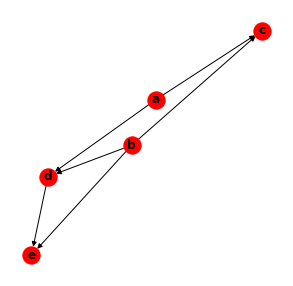

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

nx.draw(g, with_labels=True, font_weight='bold', node_color='r', ax=ax)

In [5]:
ddf = df.copy(deep=True)
for col in ddf.columns:
    ddf[col] = ddf[col].astype(str)
    
ddf.dtypes

a    object
b    object
c    object
d    object
e    object
dtype: object

In [6]:
from itertools import combinations
import numpy as np

def get_parameters(ddf, g):
    def get_filters(ch, parents, domains):
        pas = parents[ch]
        if len(pas) == 0:
            ch_domain = domains[ch]
            return [f'{ch}=="{v}"' for v in ch_domain]
        else:
            vals = [[(pa, v) for v in domains[pa]] for pa in pas]
            vals = vals + [[(ch, v) for v in domains[ch]]]
            vals = chain(*vals)
            vals = combinations(vals, len(pas) + 1)
            vals = filter(lambda tups: tups[0][0] != tups[1][0] and tups[0][0] != tups[2][0] and tups[1][0] != tups[2][0], vals)
            vals = map(lambda tups: ' and '.join([f'{t[0]}=="{t[1]}"' for t in tups]), vals)
            vals = list(vals)
            return vals

    def get_total(filters, n):
        counts = [ddf.query(f).shape[0] for f in filters]
        counts = [counts[i:i + n] for i in range(0, len(counts), n)]
        counts = [list(np.array(arr) / sum(arr)) for arr in counts]
        counts = list(chain(*counts))
        return counts

    nodes = list(g.nodes())
    
    domains = {n: sorted(list(ddf[n].unique())) for n in nodes}
    parents = {ch: list(g.predecessors(ch)) for ch in nodes}

    return {ch: get_total(get_filters(ch, parents, domains), len(domains[ch])) for ch in nodes}

get_parameters(ddf, g)

{'a': [0.1893, 0.8107],
 'b': [0.8029, 0.1971],
 'c': [0.8085526315789474,
  0.19144736842105264,
  0.2225201072386059,
  0.7774798927613941,
  0.8010447073283147,
  0.19895529267168535,
  0.2146433041301627,
  0.7853566958698373],
 'd': [0.7703947368421052,
  0.22960526315789473,
  0.8257372654155496,
  0.1742627345844504,
  0.7970502381318175,
  0.2029497618681825,
  0.8041301627033792,
  0.19586983729662077],
 'e': [0.9053310268910206,
  0.0946689731089794,
  0.11197604790419162,
  0.8880239520958084,
  0.903954802259887,
  0.096045197740113,
  0.08465608465608465,
  0.9153439153439153]}